In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# PCA para acelerar algoritmos de machine learning  

#### Vamos a ver una prueba de concepto donde nuestro objetivo es ver como PCA puede reducir nuestro tiempo de procesamiento 

Vamos a utilizar MINST dataset que se compone de imagenes de 28x28 pixeles de numeros escritos a mano. 

Cada data point de MNIST es una imagen. Cada imagen es un array de 28x28 con numeros que describen cuan negro es el pixel. 

Si lo ponemos en un vector cada imagen tiene una dimensionalirdad de  784 (28x28) donde cada uno tiene un valor entre zero y uno. 

Mas informacion del dataset y como analizarlo:

https://colah.github.io/posts/2014-10-Visualizing-MNIST/

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
#Vemos que mnist es un diccionario donde los datos se encuentran en "data"
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'categories': {},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixe

In [4]:
X = mnist.data[:10000]
mnist.data.shape
#Sabemos que hay 70000 imagenes con la dimensionalidad antes mencionada
# Me quedo con 10K porque el split se rompe, entonces se cortó ahí
# pero solo por eso, no es tan grave

(70000, 784)

In [5]:
np.unique(mnist.target)
#Los labels son valores que van del 0 al 9 

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [6]:
y = mnist.target[:10000]
mnist.target.shape

(70000,)

In [7]:
# Yo podría hacer una función de shuffle para poder usar el dataset entero

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1/7.0, random_state=0)

In [8]:
# Scalamos nuestros datos
# Al aplicar PCA si o si hay que estandarizar, porque es sensible a la escala
# que tenga las features. 
# Si tengo features con dimensiones no comparables, no va a dar bien
scaler = StandardScaler()
scaler.fit(x_train)

# Esto es importante para no mezclar información.
# Transformo en base al train
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Vamos reducir el dataset original en diferentes proporciones y ver cuales son los tiempos de entrenamientos

#### 1 - Entendemos la relacion entre la varianza explicada y la cantidad de componentes elegidos

In [9]:
from sklearn import decomposition
pca = decomposition.PCA()

pca.n_components = 784
pca_data = pca.fit_transform(x_train)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

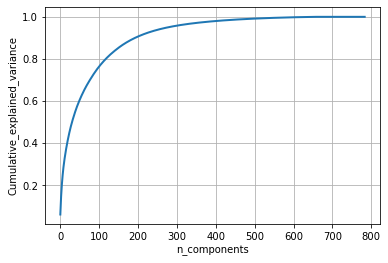

In [11]:
# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()
# Grafico las varianzas explicadas, en función de los componentes
# Yo puedo explicar el 80% de la variabilidad de mis datos con unos 120 componentes


#### 2 - Entrenamos la regresion logistica sin aplicar PCA

In [12]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
start = time.time()
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(x_train, y_train)
stop = time.time()
time_100 = stop - start
print(f"Training time: {time_100}s")
score_100 = logisticRegr.score(x_test, y_test)
print("Score:", score_100)

# entreno con todo el dataset de train

Training time: 4.920338153839111s
Score: 0.8817354793561931


#### 3 - Entrenamos la regresion logistica PCA 95% de varianza

In [13]:
# Make an instance of the Model
pca_95 = PCA(.95)
pca_95.fit(x_train)
n_95 = pca_95.n_components_ 
print(pca_95.n_components_ )

# Ahora al train full, le aplico PCA, 95% de explicación de variabilidad

278


In [14]:
x_train_95 = pca_95.transform(x_train)
x_test_95 = pca_95.transform(x_test)

In [15]:
# Ahora con estas 278, vuelvo a correr la regresión, veo que el score sube y baja el tiempo
# el score es el accuracy del entrenamiento
# está relacionado con sacar el ruido o features que no me aportan
start_95 = time.time()
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(x_train_95, y_train)
stop_95 = time.time()
time_95 = stop_95 - start_95
print(f"Training time: {time_95}s")
score_95 = logisticRegr.score(x_test_95, y_test)
print("Score:", score_95)

Training time: 2.272616386413574s
Score: 0.900629811056683


#### 4 - Entrenamos la regresion logistica PCA 80% de varianza

In [16]:
# Make an instance of the Model
pca_80 = PCA(.80)
pca_80.fit(x_train)

x_train_80 = pca_80.transform(x_train)
x_test_80 = pca_80.transform(x_test)
n_80 = pca_80.n_components_ 
print(n_80)

118


In [17]:
# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
start_80 = time.time()
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(x_train_80, y_train)
stop_80 = time.time()
time_80 = stop_80 - start_80
print(f"Training time: {time_80}s")
score_80 = logisticRegr.score(x_test_80, y_test)
print("Score:", score_80)

Training time: 1.9749062061309814s
Score: 0.9132260321903429


#### 5 - Entrenamos la regresion logistica PCA 70% de varianza

In [18]:
# Make an instance of the Model
pca_70 = PCA(.70)
pca_70.fit(x_train)

x_train_70 = pca_70.transform(x_train)
x_test_70 = pca_70.transform(x_test)
n_70 = pca_70.n_components_ 
print(n_70)

# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
start_70 = time.time()
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(x_train_70, y_train)
stop_70 = time.time()
time_70 = stop_70 - start_70
print(f"Training time: {time_70}s")
score_70 = logisticRegr.score(x_test_70, y_test)
print("Score:", score_70)

77
Training time: 1.8904380798339844s
Score: 0.9090272918124562


#### 6 - Resumen de los resultados encontramos. Que conclusiones sacamos?

In [19]:
pd.DataFrame(data = [[1.00, 784, time_100,score_100],
                     [.95, n_95, time_95, score_95],
                     [.80, n_80, time_80, score_80],
                     [.70, n_70, time_70, score_70]],
             columns = ['Variance Retained',
                      'Number of Components', 
                      'Time (seconds)',
                      'Accuracy'])

# Al menos en entrenamiento, el que tiene mejor performance es la tercer línea

,Variance Retained,Number of Components,Time (seconds),Accuracy
0,1.00,784,4.920338,0.881735
1,0.95,278,2.272616,0.900630
2,0.80,118,1.974906,0.913226
3,0.70,77,1.890438,0.909027


Conclusiones:
Al utilizar esto, asumimos una relación lineal entre las features, el PCA asume que son lineales.
Hay muchas assumption detrás que hace que funcione o no.

## Agisnacion: Obtener la tabla anterior para el iris dataset usando un algoritmo de clasificacion a eleccion

### Comparar los resultados

In [20]:
from sklearn.datasets import load_iris
data = load_iris()

In [21]:
data

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [22]:
data.target.shape

(150,)

In [23]:
list(data.target_names)

['setosa', 'versicolor', 'virginica']

In [24]:
X = data.data[:150]
data.data.shape

(150, 4)

In [25]:
y = data.target[:150]

In [27]:
y.shape

(150,)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [40]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [41]:
pca.n_components = 4
pca_data = pca.fit_transform(x_train)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

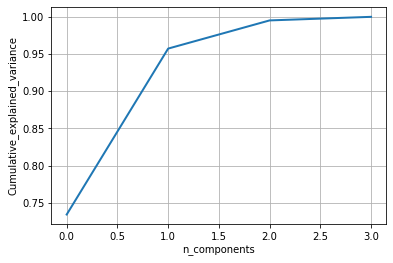

In [42]:
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [43]:
#Sin aplicar PCA

from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
start = time.time()
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(x_train, y_train)
stop = time.time()
time_100 = stop - start
print(f"Training time: {time_100}s")
score_100 = logisticRegr.score(x_test, y_test)
print("Score:", score_100)

Training time: 0.018512725830078125s
Score: 0.9


## Aplicanddo PCA 95%

In [37]:
pca_95 = PCA(.95)
pca_95.fit(x_train)
n_95 = pca_95.n_components_ 
print(pca_95.n_components_ )

2


In [38]:
x_train_95 = pca_95.transform(x_train)
x_test_95 = pca_95.transform(x_test)

In [39]:
start_95 = time.time()
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(x_train_95, y_train)
stop_95 = time.time()
time_95 = stop_95 - start_95
print(f"Training time: {time_95}s")
score_95 = logisticRegr.score(x_test_95, y_test)
print("Score:", score_95)

Training time: 0.05453681945800781s
Score: 0.8333333333333334


## Aplicando PCA 80%

In [44]:
pca_80 = PCA(.80)
pca_80.fit(x_train)

x_train_80 = pca_80.transform(x_train)
x_test_80 = pca_80.transform(x_test)
n_80 = pca_80.n_components_ 
print(n_80)

2


In [45]:
x_train_80 = pca_80.transform(x_train)
x_test_80 = pca_80.transform(x_test)

In [47]:
start_80 = time.time()
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(x_train_80, y_train)
stop_80 = time.time()
time_80 = stop_80 - start_80
print(f"Training time: {time_80}s")
score_80 = logisticRegr.score(x_test_80, y_test)
print("Score:", score_80)

Training time: 0.019514083862304688s
Score: 0.8333333333333334


## Aplicando PCA 70%

In [48]:
pca_70 = PCA(.70)
pca_70.fit(x_train)

x_train_70 = pca_70.transform(x_train)
x_test_70 = pca_70.transform(x_test)
n_70 = pca_70.n_components_ 
print(n_70)

# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
start_70 = time.time()
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(x_train_70, y_train)
stop_70 = time.time()
time_70 = stop_70 - start_70
print(f"Training time: {time_70}s")
score_70 = logisticRegr.score(x_test_70, y_test)
print("Score:", score_70)

1
Training time: 0.021515846252441406s
Score: 0.8666666666666667


## Resultados

In [50]:
pd.DataFrame(data = [[1.00, 4, time_100,score_100],
                     [.95, n_95, time_95, score_95],
                     [.80, n_80, time_80, score_80],
                     [.70, n_70, time_70, score_70]],
             columns = ['Variance Retained',
                      'Number of Components', 
                      'Time (seconds)',
                      'Accuracy'])

,Variance Retained,Number of Components,Time (seconds),Accuracy
0,1.00,4,0.018513,0.900000
1,0.95,2,0.017012,0.833333
2,0.80,2,0.019514,0.833333
3,0.70,1,0.021516,0.866667
